In [1]:
using Symbolics

# Automatic Differentiation through a Linear System of Equations
Imagine linear system solving $A x = b$, where both $A(p)$ and $b(p)$ depend on some number of parameters $p$.

In [2]:
@variables p1 p2 p3 p4;
P = [p1, p2, p3, p4]

4-element Vector{Num}:
 p1
 p2
 p3
 p4

In [3]:
with_p(x, p) = substitute(x, Dict(p1=>p[1], p2=>p[2], p3=>p[3], p4=>p[4]));

In [4]:
A = [p1 + p2 p2 - p3; p1 + p3 p4 - p1]

2×2 Matrix{Num}:
 p1 + p2   p2 - p3
 p1 + p3  -p1 + p4

In [5]:
b = [2 * p3, -p4]

2-element Vector{Num}:
 2p3
 -p4

Solve $A(p) x = b(p)$

In [6]:
x = A \ b

2-element Vector{Num}:
 (2p3 + (-(p2 - p3)*(-p4 + (-2(p1 + p3)*p3) / (p1 + p2))) / (-p1 + p4 + (-(p1 + p3)*(p2 - p3)) / (p1 + p2))) / (p1 + p2)
                                  (-p4 + (-2(p1 + p3)*p3) / (p1 + p2)) / (-p1 + p4 + (-(p1 + p3)*(p2 - p3)) / (p1 + p2))

In [7]:
P₁ = [1, 2, 3, 4]
with_p(x, P₁)

2-element Vector{Num}:
  1.0769230769230769
 -2.7692307692307696

## Assuming Direct Solve
* Given the concrete values for $P$, we create $A$ and $b$ based on these value.
* Then, we solve $A x = b$

In [8]:
A₁ = with_p(A, P₁)

2×2 Matrix{Num}:
 3  -1
 4   3

In [9]:
b₁ = with_p(b, [1 2 3 4])

2-element Vector{Num}:
  6
 -4

In [10]:
x₁ = A₁ \ b₁

2-element Vector{Num}:
  1.0769230769230769
 -2.7692307692307696

## Using $x$ for downstream tasks
Imagine we want to tune $p$ such that the resulting $x$ is as close a possible to some defined $x^*$.

In [11]:
x_star = [5, 6];

As we can see below, the error $E(P) = ||x(P) - x^*||_2$ is parametrized by $P$, and we can take the derivative of it with respect to $P$.

In [12]:
using LinearAlgebra

error = norm(x - x_star)

sqrt(abs2(-5 + (2p3 + (-(p2 - p3)*(-p4 + (-2(p1 + p3)*p3) / (p1 + p2))) / (-p1 + p4 + (-(p1 + p3)*(p2 - p3)) / (p1 + p2))) / (p1 + p2)) + abs2(-6 + (-p4 + (-2(p1 + p3)*p3) / (p1 + p2)) / (-p1 + p4 + (-(p1 + p3)*(p2 - p3)) / (p1 + p2))))

In [13]:
@variables x1 x2

with_x(expr, xs) = substitute(expr, Dict(x1 => xs[1], x2 => xs[2]))

error_x = norm([x1, x2] - x_star)

sqrt(abs2(-5 + x1) + abs2(-6 + x2))

In [14]:
using Symbolics
grad = Symbolics.gradient(error, [p1, p2, p3, p4]);
grad_x = Symbolics.gradient(error_x, [x1, x2]);

In [15]:
grad₁ = with_p(grad, P₁)

4-element Vector{Num}:
  0.7300271787188278
  0.31583340948466415
  0.11712274051096448
 -0.4282655548052625

In [16]:
P₂ = P₁ - 0.01 * grad₁

4-element Vector{Num}:
 0.9926997282128117
 1.9968416659051533
 2.9988287725948903
 4.004282655548052

In [17]:
with_p(error, P₁), with_x(error_x, x₁)

(9.606765367614761, 9.606765367614761)

In [18]:
with_p(error, P₂)

9.59849043167196

In [19]:
function update(P)
    ∇P = with_p(grad, P)
    return P - 0.01 * ∇P
end

update (generic function with 1 method)

In [20]:
using Printf

function opt(initial_params, update_fn, err_fn, x_fn; n_iterations = 1000)
    errors = []
    xs = []

    Pᵢ = initial_params
    for idx in 1:n_iterations
        new_P = update_fn(Pᵢ)
        if isapprox(new_P, Pᵢ, atol=1e-3)
            println("Iteration $idx. Update did not change parameters. Exiting opt()")
            return errors, xs
        end        
        Pᵢ = new_P

        if idx % 10 == 0
            errᵢ = err_fn(Pᵢ)
            xᵢ = x_fn(Pᵢ)
            push!(errors, errᵢ)
            push!(xs, xᵢ)
        end
        if idx % 100 == 0
            println("Iteration $idx. Error: ", errᵢ, " x= ", xᵢ)
        end
    end

    return errors, xs
end

opt (generic function with 1 method)

In [21]:
using Plots

function plot_opt(xs)
    x1s = [x[1].val for x in xs];
    x2s = [x[2].val for x in xs];

    plot(x1s, x2s, seriestype = :scatter, xlabel = "x1", ylabel = "x2", label = "Evolution of x")
    scatter!([x_star[1]], [x_star[2]], label="Target x*")
    quiver!(x1s[1:end-1], x2s[1:end-1], quiver=(diff(x1s), diff(x2s)))
end

plot_opt (generic function with 1 method)

Iteration 100. Error: 9.00279366810073 x= Num[1.5293935800469163, -2.306935951852227]
Iteration 200. Error: 8.438700623659624 x= Num[2.338741809190859, -2.0080817339488095]
Iteration 300. Error: 7.514297274683341 x= Num[4.322450075232488, -1.4836882372103808]
Iteration 400. Error: 6.070984278632055 x= Num[5.783288363470014, -0.02024164390849418]
Iteration 500. Error: 7.82401602088642 x= Num[0.603574162627048, -0.4719909264125911]
Iteration 600. Error: 7.1526301816727855 x= Num[1.487497426967115, -0.2307659392897936]
Iteration 700. Error: 4.796236293824541 x= Num[4.911413566620401, 1.204581871200296]
Iteration 800. Error: 5.978286530116765 x= Num[2.63824896030075, 0.5080020154177887]
Iteration 900. Error: 6.050205961109723 x= Num[2.4059135849459095, 0.5341324711369514]
Iteration 1000. Error: 4.534182352329859 x= Num[8.730744448087265, 3.4231112815556854]


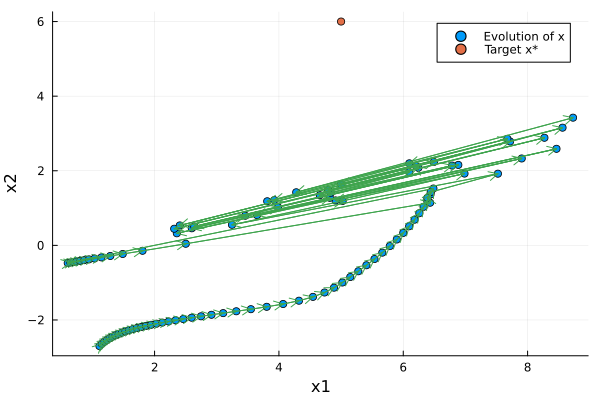

In [22]:
errors, xs = opt(P₁, update, p -> with_p(error, p), p -> with_p(x, p));
plot_opt(xs)

In [23]:
function update_x(x)
    ∇x = with_x(grad_x, x)
    return x - 0.1 * ∇x
end

_, xs = opt(x₁, update_x, x -> with_x(error_x, x), x -> x, n_iterations=200);

Iteration 100. Error: 0.006765367614751683 x= Num[4.997237253482318, 5.993824448960476]
Iteration 200. Error: 0.006765367614751683 x= Num[4.997237253482318, 5.993824448960476]


In [24]:
xs

20-element Vector{Any}:
 Num[1.4852891369813308, -1.8564125173358477]
 Num[1.8936551970395847, -0.9435942654409275]
 Num[2.30202125709784, -0.030776013546007022]
 Num[2.7103873171560933, 0.8820422383489135]
 Num[3.1187533772143468, 1.7948604902438337]
 Num[3.527119437272601, 2.7076787421387554]
 Num[3.9354854973308555, 3.6204969940336778]
 Num[4.343851557389112, 4.5333152459286]
 Num[4.752217617447367, 5.4461334978235225]
 Num[4.997237253482318, 5.993824448960476]
 Num[4.997237253482318, 5.993824448960476]
 Num[4.997237253482318, 5.993824448960476]
 Num[4.997237253482318, 5.993824448960476]
 Num[4.997237253482318, 5.993824448960476]
 Num[4.997237253482318, 5.993824448960476]
 Num[4.997237253482318, 5.993824448960476]
 Num[4.997237253482318, 5.993824448960476]
 Num[4.997237253482318, 5.993824448960476]
 Num[4.997237253482318, 5.993824448960476]
 Num[4.997237253482318, 5.993824448960476]

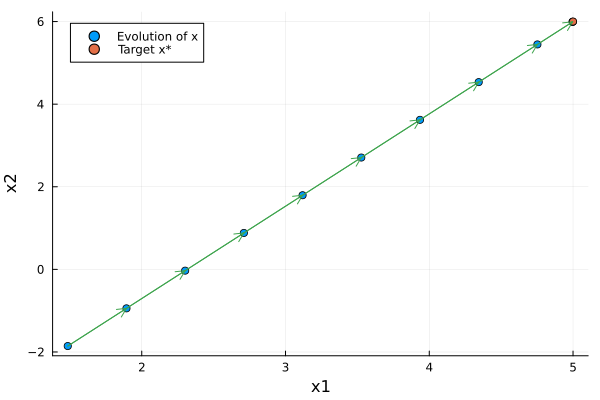

In [25]:
plot_opt(xs[1:11])